# Download the dataset

In [ ]:
# Install gdown
!pip install gdown

# Import libraries
import pandas as pd
import numpy as np
import zipfile
import gdown

# Download and extract the dataset
url = 'https://drive.google.com/uc?id=1X3IpoYxAJHIBlyG6QQ_rWhSGiF5E1aL8'
output = '/content/dataset-ml-25m.zip'
gdown.download(url, output, quiet=False)

with zipfile.ZipFile('/content/dataset-ml-25m.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From: https://drive.google.com/uc?id=1X3IpoYxAJHIBlyG6QQ_rWhSGiF5E1aL8
To: /content/dataset-ml-25m.zip
100%|██████████| 262M/262M [00:08<00:00, 29.1MB/s]


# Main code to train and Evaluation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-90-cbcdefe4f062>:98: FutureWarning: The default value of regex will change from True to False in a future version.
  movies['title'] = movies['title'].str.replace('(\(\d{4}\))', '').apply(lambda x: x.strip())


movieId        0
title          0
genres         0
year         410
genre_ids      0
dtype: int64
      movieId                                        title  \
15036   79607      Millions Game, The (Das Millionenspiel)   
25387  123619                           Terrible Joe Moran   
26284  125571         The Court-Martial of Jackie Robinson   
26309  125632                                In Our Garden   
26392  125958           Stephen Fry In America - New World   
...       ...                                          ...   
62071  207714                       Tales of Found Footage   
62104  207884                             Enduring Destiny   
62285  208597  Punk the Capital: Building a Sound Movement   
62326  208763                 Yosemite: The Fate of Heaven   
62380  208973          The Falklands War: The Untold Story   

                                  genres  year  \
15036  [Action, Drama, Sci-Fi, Thriller]   NaN   
25387               [(no genres listed)]   NaN   
26284  

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


num_movies: 209172
num_users: 16658
num_genres: 5
Number of training samples: 2000007


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4096])) that is different to the input size (torch.Size([4096, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100it [05:22,  3.15s/it]

[1,   100] loss: 4.314


200it [10:47,  3.13s/it]

[1,   200] loss: 1.248


300it [16:06,  3.26s/it]

[1,   300] loss: 1.212


400it [21:12,  3.02s/it]

[1,   400] loss: 1.183


488it [25:39,  3.15s/it]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


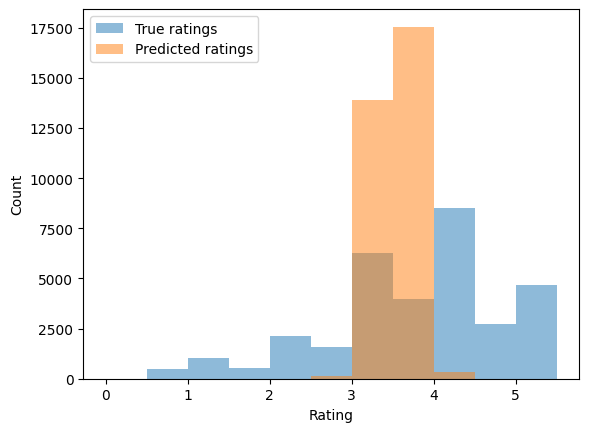

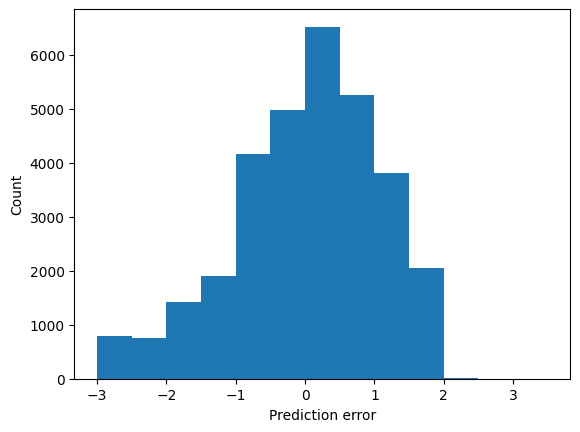

Test RMSE: 0.274
Test precision: 62.306 %
Test recall: 100.000 %
Test F1 score: 76.776 %


In [ ]:
# Import libraries
!pip install nearpy
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections
from nearpy.filters import NearestFilter
from nearpy.distances import CosineDistance
from torch.utils.data import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

class MovieLensNet(nn.Module):
    def __init__(self, num_movies, num_users, num_genres_encoded, embedding_size, hidden_dim):
        super(MovieLensNet, self).__init__()
        self.num_movies = num_movies
        self.num_users = num_users
        self.num_genres_encoded = num_genres_encoded
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.fc1 = nn.Linear(embedding_size * 2 + num_genres_encoded, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, movie_id, user_id, genre_id):
        genre_id = torch.unsqueeze(genre_id, dim=2)
        if genre_id.size() != (movie_id.size(0), self.num_genres_encoded, 1):
            raise ValueError(f"Expected genre_id to have size ({movie_id.size(0)}, {self.num_genres_encoded}, 1), but got size {genre_id.size()}")
        movie_emb = self.movie_embedding(movie_id)
        user_emb = self.user_embedding(user_id)
        movie_emb = torch.unsqueeze(movie_emb, dim=2)
        user_emb = torch.unsqueeze(user_emb, dim=2)
        x = torch.cat([movie_emb, user_emb, genre_id.float()], dim=1)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class MovieLensDataset(torch.utils.data.Dataset):
    def __init__(self, data, movies, genres_encoded, mlb, max_genre_count, num_users):
        self.data = data
        self.movies = movies
        self.genres_encoded = genres_encoded
        self.mlb = mlb
        self.max_genre_count = max_genre_count
        self.num_users = num_users

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        movie_id = torch.tensor(row["movieId"], dtype=torch.long)
        user_id = torch.tensor(row["userId"], dtype=torch.long)
        if user_id.min() < 0 or user_id.max() >= self.num_users:
            print('self.num_users = ' , self.num_users)
            raise ValueError(f"Invalid user ID: {user_id}")
        movie_genres = self.movies.loc[self.movies['movieId'] == row['movieId'], 'genres'].iloc[0]
        genre_indices = []
        for genre in movie_genres.split('|'):
            if genre in self.mlb.classes_:
                genre_indices.append(np.where(self.mlb.classes_ == genre)[0][0])
        if len(genre_indices) == 0:  # Add default value for empty genre tensor
            genre_indices.append(0)
        genre_id = torch.tensor(genre_indices, dtype=torch.long)
        genre_id = torch.flatten(genre_id)[:self.max_genre_count]
        genre_pad = torch.zeros(self.max_genre_count - genre_id.shape[0], dtype=torch.long)
        genre_id = torch.cat([genre_id, genre_pad])
        rating = torch.tensor(row["rating"], dtype=torch.float)
        return {"movie_id": movie_id, "user_id": user_id, "genre_id": genre_id, "rating": rating}



# Load the dataset
movies = pd.read_csv('/content/ml-25m/movies.csv')
ratings = pd.read_csv('/content/ml-25m/ratings.csv')

# choose 10 percent for faster result
ratings = ratings.sort_values('userId')
ratings = ratings.reset_index(drop=True)
ten_percent = int(len(ratings) * 0.1)
ratings = ratings.iloc[:ten_percent]

# Clean the movies dataframe
movies['year'] = movies['title'].str.extract('\((\d{4})\)', expand=False)
movies['year'] = pd.to_datetime(movies['year'], format='%Y').dt.year
movies['title'] = movies['title'].str.replace('(\(\d{4}\))', '').apply(lambda x: x.strip())

# Filter the rating data to include only valid movie IDs
valid_movie_ids = set(movies['movieId'])
ratings = ratings[ratings['movieId'].isin(valid_movie_ids)]

# Fill missing values in ratings dataframe
ratings['rating'].fillna(ratings['rating'].mean(), inplace=True)

# Redefine genre IDs
movies['genres'] = movies['genres'].str.split('|')
mlb = MultiLabelBinarizer()
movies['genre_ids'] = mlb.fit_transform(movies['genres']).tolist()

# Redefine movie IDs
movies['movieId'] = movies['movieId'].astype('category')
movies['movieId'] = movies['movieId'].cat.as_ordered()

# Redefine user IDs
ratings['userId'] = ratings['userId'].astype('category')
ratings['userId'] = ratings['userId'].cat.codes

# Check for missing or invalid values in movies dataframe
print(movies.isnull().sum())
print(movies[movies['year'].isnull()])

# Check for missing or invalid values in ratings dataframe
print(ratings.isnull().sum())

# Convert movie genres to a list of strings
movies['genres'] = movies['genres'].apply(lambda x: '|'.join(x))

# Create a content-based filtering algorithm based on movie genres
vectorizer = CountVectorizer(tokenizer=lambda x: x.split('|'))
movie_genres = vectorizer.fit_transform(movies['genres'])
mlb = MultiLabelBinarizer(sparse_output=True)
genres_encoded = mlb.fit_transform(list(vectorizer.vocabulary_.keys()))
genres_encoded = genres_encoded.astype(np.float32)

# Define the dataset and dataloader
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)
num_users = ratings['userId'].max() + 1
num_movies = max(ratings['movieId'].max(), movies['movieId'].max()) + 1
num_genres = 5
# max(genres_encoded.shape[1], len(mlb.classes_))

train_dataset = MovieLensDataset(train_data, movies, genres_encoded, mlb, max_genre_count=5, num_users=num_users)
test_dataset = MovieLensDataset(test_data, movies, genres_encoded, mlb, max_genre_count=5, num_users=num_users)
import random
from torch.utils.data import Subset

# Define the downsampling factor
downsample_factor = 1 # Use % of the data
stop_i = 500 # for fast checking
number_epochs = 1
# Create a list of indices for the train and test sets
num_train = len(train_data)
train_indices = list(range(num_train))
num_test = len(test_data)
test_indices = list(range(num_test))

# Randomly select a subset of the train and test indices
random.shuffle(train_indices)
random.shuffle(test_indices)
train_indices = train_indices[:int(downsample_factor*num_train)]
test_indices = test_indices[:int(downsample_factor*num_test)]

# Create subsets of the train and test datasets
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

# Create the train and test DataLoader objects with the subsets
train_loader = DataLoader(train_subset, batch_size= 4096, shuffle=True, drop_last=True)
test_loader = DataLoader(test_subset, batch_size=4096, shuffle=False, drop_last=True)
# Set the hyperparameters and train the model
embedding_dim = 16
hidden_dim = 32
dropout_p = 0.5

print(f'num_movies: {num_movies}')
print(f'num_users: {num_users}')
print(f'num_genres: {num_genres}')

model = MovieLensNet(num_movies,num_users, num_genres, embedding_size=32, hidden_dim=64)
num_train_samples = len(train_loader.dataset)
print(f"Number of training samples: {num_train_samples}")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(number_epochs):
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_loader)):
        movie_id = batch['movie_id']
        user_id = batch['user_id']
        genre_id = batch['genre_id']
        rating = batch['rating']
        # print(f'movie_id shape: {movie_id.shape}')
        # print(f'user_id shape: {user_id.shape}')
        # print(f'genre_id shape: {genre_id.shape}')
        # print('user_id' , user_id)
        # print('model.num_users = ' , model.num_users)
        output = model(movie_id, user_id, genre_id)
        # print(f'output shape: {output.shape}')
        loss = criterion(output, rating)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i + 1) % 100 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

        if i+1 == stop_i:
          break

# Evaluate the model on the test set
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
model.eval()
with torch.no_grad():
    total_loss = 0.0
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    # Collect the predicted ratings and true ratings
    all_predicted_ratings = []
    all_true_ratings = []

    for i, batch in enumerate(test_loader):
        if i+1 == stop_i:
          break
        movie_id = batch['movie_id']
        user_id = batch['user_id']
        genre_id = batch['genre_id']
        rating = batch['rating']
        output = model(movie_id, user_id, genre_id)
        loss = criterion(output, rating)
        total_loss += loss.item()
        predicted_labels = (output >= 2).float()  # Threshold at 4 or higher
        tp += ((predicted_labels == 1) & (rating >= 3.5)).sum().item()
        fp += ((predicted_labels == 1) & (rating < 3.5)).sum().item()
        tn += ((predicted_labels == 0) & (rating < 3.5)).sum().item()
        fn += ((predicted_labels == 0) & (rating >= 3.5)).sum().item()

        all_predicted_ratings.extend(output.squeeze().tolist())
        all_true_ratings.extend(rating.squeeze().tolist())

    # Plot distribution of true and predicted ratings
    plt.hist(all_true_ratings, bins=np.arange(0, 6, 0.5), alpha=0.5, label='True ratings')
    plt.hist(all_predicted_ratings, bins=np.arange(0, 6, 0.5), alpha=0.5, label='Predicted ratings')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    # Plot distribution of prediction errors
    errors = np.array(all_true_ratings) - np.array(all_predicted_ratings)
    plt.hist(errors, bins=np.arange(-3, 4, 0.5))
    plt.xlabel('Prediction error')
    plt.ylabel('Count')
    plt.show()


    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    fig.tight_layout()
    plt.show()
    avg_loss = total_loss / len(test_loader)
    print('Test RMSE: %.3f' % np.sqrt(avg_loss))
    precision = tp / (tp + fp+0.000001)*100
    recall = tp / (tp + fn+0.000001)*100
    f1 = 2 * precision * recall / (precision + recall+0.000001)
    print('Test precision: %.3f' % precision + ' %')
    print('Test recall: %.3f' % recall + ' %')
    print('Test F1 score: %.3f' % f1 + ' %')
    # Compute the optimal threshold
    thresholds = np.arange(2, 5.0, 0.1)
    f1_scores = []
    for threshold in thresholds:
        predicted_labels = (torch.Tensor(all_predicted_ratings) >= threshold).float()
        tp = ((predicted_labels == 1) & (torch.Tensor(all_true_ratings) >= 3.5)).sum().item()
        fp = ((predicted_labels == 1) & (torch.Tensor(all_true_ratings) < 3.5)).sum().item()
        tn = ((predicted_labels == 0) & (torch.Tensor(all_true_ratings) < 3.5)).sum().item()
        fn = ((predicted_labels == 0) & (torch.Tensor(all_true_ratings) >= 3.5)).sum().item()
        precision = tp / (tp + fp+0.000001)
        recall = tp / (tp + fn+0.000001)
        f1 = 2 * precision * recall / (precision + recall+0.000001)
        f1_scores.append(f1)
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    # print('Optimal threshold:', optimal_threshold)